In [1]:
import os
import numpy as np
import cv2
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Flatten, Dropout, ELU
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
IMG_DIR = "data/IMG"

In [3]:
def make_model():
    inputs = Input(shape=(32, 32, 3))

    x = Convolution2D(3, 1, 1, activation='relu')(inputs)
    
    # Stage 1    
    x = Convolution2D(8, 5, 5, activation='relu')(inputs)
    x = MaxPooling2D((2,2))(x)
    
    # Stage 2
    x = Convolution2D(16, 5, 5, activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    
    # Dense Layer
    x = Flatten()(x)
    
    # Hidden Layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # classifer
    predictions = Dense(1)(x)
    
    model = Model(input=inputs, output=predictions)
#     opt = Adam(lr=1e-4)
    model.compile(optimizer='adam', #Adam(lr=1e-4),
              loss='mse',
              metrics=['mse'])
    
    return model

In [4]:
model = make_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 8)     608         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 8)     0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 10, 10, 16)    3216        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [5]:
def save_model(model, filename):
    with open(filename, "w") as f:
        f.write(model.to_json())
    print("Model architecture saved to:", filename)
    
save_model(model, "model.json")    

Model architecture saved to: model.json


In [6]:
def load_data(filename):
    with np.load(filename) as f:
        X_train = f['X_train']
        y_train = f['y_train']
        X_val = f['X_val']
        y_val = f['y_val']
        
    print("\nTrain:")
    print(X_train.shape, X_train.dtype)
    print(y_train.shape, y_train.dtype, y_train.min(), y_train.max())
    
    print("\nValidation:")
    print(X_val.shape, X_val.dtype)
    print(y_val.shape, y_val.dtype, y_val.min(), y_val.max())
    return (X_train, y_train), (X_val, y_val)

(X_train, y_train), (X_val, y_val) = load_data("data/img_labels.npz")


Train:
(43394,) <U13
(43394,) float64 -1.0 1.0

Validation:
(4822,) <U13
(4822,) float64 -0.8954403 0.8380292


In [7]:
def get_images(fnames):
#     read_gray = lambda f: cv2.cvtColor(plt.imread(os.path.join(IMG_DIR, f)), cv2.COLOR_RGB2YUV)[:,:,0,None]
#     imgs = np.asarray([read_gray(f) for f in fnames], dtype=np.float32)
    imgs = np.asarray([plt.imread(os.path.join(IMG_DIR, f)) for f in fnames], dtype=np.float32)
    return (imgs / 127.5) - 1.

def data_generator(X, y, batch_size, shuffle):
    def generator():
        idx = np.arange(X.shape[0])
        steps = X.shape[0] // batch_size
        while True:
            if shuffle: np.random.shuffle(idx)
            for c in range(steps):
                offset = c * batch_size
                batch_idx = idx[offset:offset + batch_size]
                yield get_images(X[batch_idx]), y[batch_idx]
                
    return generator   

In [8]:
BATCH_SIZE = 128
train_gen = data_generator(X_train, y_train, BATCH_SIZE, True)
val_gen = data_generator(X_val, y_val, BATCH_SIZE, False)

# prev_hist = None

In [9]:
prev_hist = None

In [18]:
# Train model
hist = model.fit_generator(train_gen(), 
                           samples_per_epoch=X_train.shape[0] - (X_train.shape[0] % BATCH_SIZE), 
                           nb_epoch=5, 
                           validation_data=val_gen(),
                           nb_val_samples=X_val.shape[0] - (X_val.shape[0] % BATCH_SIZE),
                           initial_epoch=0)

Epoch 1/5
43392/43392 [==============================] - 115s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2/5
43392/43392 [==============================] - 111s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/5
43392/43392 [==============================] - 111s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 4/5
43392/43392 [==============================] - 118s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 5/5
43392/43392 [==============================] - 115s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


In [19]:
if prev_hist is None:
    prev_hist = hist.history
else:
    for k, v in hist.history.items():
        prev_hist[k].extend(v)

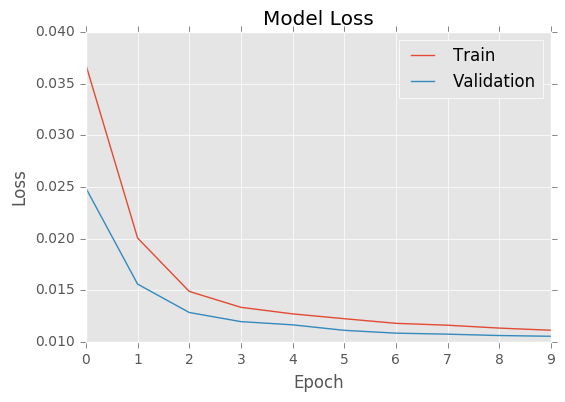

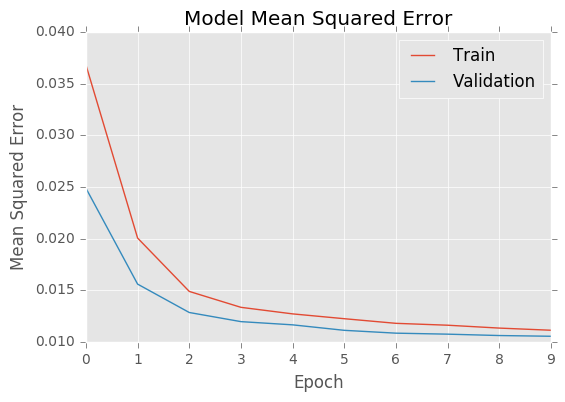

In [20]:
def plot_hist(train, val, label):
    # summarize history for accuracy
    plt.plot(train)
    plt.plot(val)
    plt.title('Model ' + label)
    plt.ylabel(label)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

plot_hist(prev_hist['loss'],
          prev_hist['val_loss'],
          'Loss')

plot_hist(prev_hist['mean_squared_error'],
          prev_hist['val_mean_squared_error'],
          'Mean Squared Error')

In [21]:
# Save model weights
def save_weigths(model, filename):
    model.save_weights(filename)
    print("Model weights saved to:", filename)
save_weigths(model, "model.h5")

Model weights saved to: model.h5


In [14]:
import keras.backend as K
import math

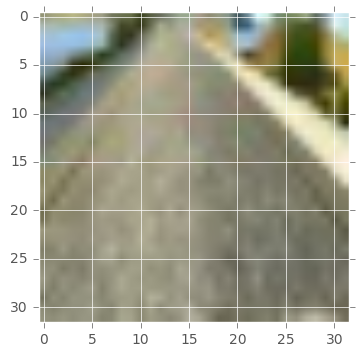

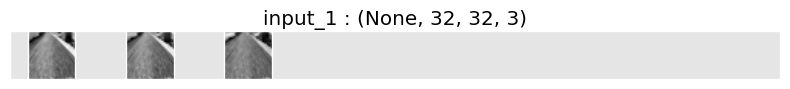

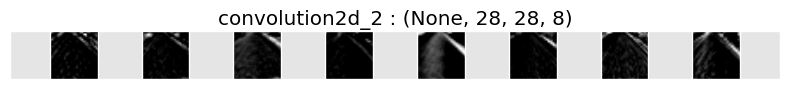

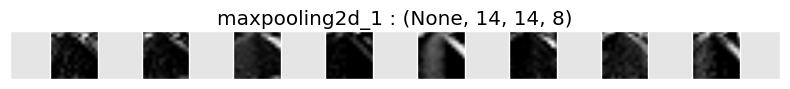

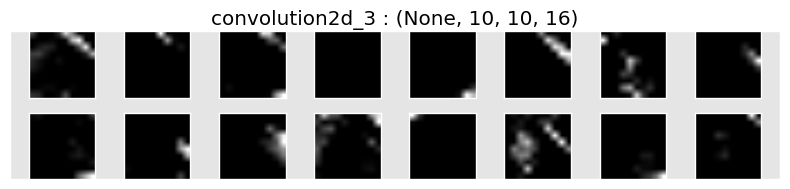

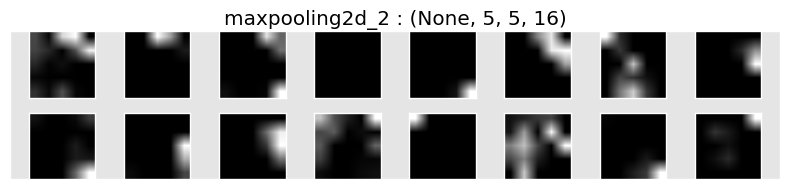

flatten_1 : (None, 400) : [ 0.0906058   0.          0.          0.          0.          0.
  0.10052683  0.          0.02880688  0.        ]
dense_1 : (None, 256) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
dropout_1 : (None, 256) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
dense_2 : (None, 128) : [ 0.          0.04519285  0.02904039  0.          0.          0.
  0.02837992  0.02207812  0.          0.07903092]
dropout_2 : (None, 128) : [ 0.          0.04519285  0.02904039  0.          0.          0.
  0.02837992  0.02207812  0.          0.07903092]
dense_3 : (None, 1) : [ 0.14208551]


11

In [17]:
def temp_func():
    
    def show_sample(entry, title=''):
        if len(entry.shape) < 3:
            print(title, ':', entry[:10])
            return
        
        count = entry.shape[2]
        cols = 8
        rows = math.ceil(count / cols)
        
        fig = plt.figure(figsize=(8, 1 * rows))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        for i in range(count):
            ax = fig.add_subplot(rows, cols, i + 1)
            img = entry[...,i]
            ax.imshow(img, cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            
        plt.show()
        
    fname = X_train[3000]
    fname = X_train[500]
#     fname = X_train[200]
#     fname = X_train[0]
#     fname = X_train[2000]

    orig_img = plt.imread(IMG_DIR + '/' + fname)
    plt.imshow(orig_img)
    plt.show()
    
    img = get_images([fname])
    
    func = K.function([model.layers[0].input, K.learning_phase()],
                      [l.output for l in model.layers])
    res = func([img, 0]) # 0 = test, 1 = train
    
    for i, r in enumerate(res):
        layer = model.layers[i]
        show_sample(r[0], '{} : {}'.format(layer.get_config()['name'], layer.output_shape))

    return len(res)
temp_func()